In [1]:
from IM_env_5_2 import InventoryEnv
import collections
import numpy as np
import random
import pickle

In [2]:
m=50    #max capacity of warehouse

### If a Q-dictionary does not exist, run the following cell to initialise an empty dictionary:

In [11]:
Q_dict = collections.defaultdict(dict)

States_track = collections.defaultdict(dict)

rewards_tracked = {(15,0):[],(25,1):[], (20,2): [], (30,3):[], (35,4):[], (10,5):[],(50,6):[]}


print(len(Q_dict))
print(len(rewards_tracked))
print(len(States_track))

0
7
0


### If a Q-dictionary already exists, run the following cell to import the latest dictionary:

In [33]:
with open('Policy.pkl', 'rb') as handle:
    Q_dict = pickle.load(handle)
    
with open('Rewards.pkl', 'rb') as handle:
    rewards_tracked = pickle.load(handle)    

with open('States_tracked.pkl', 'rb') as handle:
    States_track = pickle.load(handle)    
    
print(len(Q_dict))
print(len(rewards_tracked))
print(len(States_track))

248
7
7


In [34]:
#Defining a function which will return valid actions corresponding to a state

def valid_actions(state):
    
    state = int(state[0])
    valid_Actions = []
    
    for ix in range(0,m+1):
        valid_Actions.append(ix)
    return valid_Actions

In [35]:
#Defining a function which will add new Q-values to the Q-dictionary

def add_to_dict(state,valid_act):
    
    if state not in Q_dict.keys():
        Q_dict[state] = {}
        for action in valid_act:
            Q_dict[state][action] = 0.0

In [36]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [37]:
#This function will initialise the 7 Q-values which need to be tracked for checking convergence

#iters = []                            #the x-axis of convergence graphs

def initialise_tracking_states():
    sample_q_values = [((15,0),12),((25,1),25),((20,2),10),((30,3),30),((35,4),15),((10,5),18),((50,6),10)]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         

In [38]:
#This function will append latest Q-values of the 4 Q-values which are being tracked for checking convergence

def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])            

In [39]:
def epsilon_greedy(state, time):
    epsilon = - 1/ (1 + np.exp((-time+7500000)/1700000)) + 1
    z = np.random.random()
        
    if z > epsilon:
        action = max(Q_dict[state],key=Q_dict[state].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        action = np.random.choice(np.arange(0,m+1))    #Exploration: randomly choosing and action
    
    return action

### Training

In [40]:
#Defining parameters for the experiment

EPISODES = 20
#EPISODES = 15000000
#STEPS = 2
STEPS = 30                 #for 30 days
LR = 0.01                   #learning rate
GAMMA = 0.91


# threshold = 2000       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
threshold = 1
#policy_threshold = 30000    #every these many episodes, the Q-dict will be updated
policy_threshold = 3

In [65]:
for episode in range(0,EPISODES):
#for episode in range(6393884,EPISODES):

    
    env = InventoryEnv()      #creating an instance of the class
    #this initialises the state back to some initial value which is required for every new episode
    #this also initialises all parameters like m,p,K, etc.
    
    initial_state = env.state    #for the purpose of tracking reward
    curr_state = env.state     #note that we are starting on this day's evening because action is taken in the evening
    #curr_state is state_mon
    
    add_to_dict(curr_state,valid_actions(curr_state))
    
    #reward is not calculated for the immediately next day
    time_step = 0
    reward = None
    curr_action = np.random.choice(np.arange(0,m+1))    #randomly choosing and action
    #curr_action is a_mon
    
    next_state = env.initial_step(curr_state, curr_action)   #returned state_tue
    
    add_to_dict(next_state,valid_actions(next_state))

    curr_state = next_state       #state_tue became state(t-1)
    
    #note that curr_state is always previous day evening's stock
    
    total_reward = 0
    
    
    while time_step < STEPS:    #the episode will run only for a few steps and not infinitely
        
        #curr_action is a_tue and is a(t-1)      
        curr_action = epsilon_greedy(curr_state, episode)
        
        next_state, reward = env.step(curr_state, curr_action)
        #next_state is state_wed 
        
        add_to_dict(next_state,valid_actions(next_state))
            
        # UPDATE RULE
        max_next = max(Q_dict[next_state],key=Q_dict[next_state].get)   #this gets the action corresponding to max q-value of next state
        Q_dict[curr_state][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state][max_next]))) - Q_dict[curr_state][curr_action] ) 


        curr_state = next_state       #state(t) became state(t-1)

        total_reward += reward
        
        time_step += 1

    
    #TRACKING REWARDS
    if initial_state in rewards_tracked:     #storing rewards
        rewards_tracked[initial_state].append(total_reward)
        #save_obj(rewards_tracked,'Rewards')

    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_obj(rewards_tracked,'Rewards')   
    
    #TRACKING Q-VALUES
    if (episode == threshold-1):        #at the 1999th episode
        initialise_tracking_states()
      
    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')    
        
        
save_obj(rewards_tracked,'Rewards')   
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')      
print(episode)

19


In [42]:
episode

19

In [43]:
save_obj(rewards_tracked,'Rewards')   
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')      

### Checking Values

In [44]:
len(Q_dict.keys())      #max should be 51*7

322

In [45]:
51*7

357

In [46]:
Q_dict

defaultdict(dict,
            {(47, 6): {0: 0.0,
              1: 0.0,
              2: 0.0,
              3: 0.0,
              4: 0.0,
              5: 0.0,
              6: 0.0,
              7: 0.0,
              8: 0.0,
              9: 0.0,
              10: 0.0,
              11: 0.0,
              12: 0.0,
              13: 0.0,
              14: 0.0,
              15: 0.0,
              16: 0.0,
              17: 0.0,
              18: 0.0,
              19: 0.0,
              20: 0.0,
              21: 0.0,
              22: -0.040761874999999996,
              23: 0.0,
              24: 0.0,
              25: 0.0,
              26: 0.0,
              27: 0.0,
              28: 0.0,
              29: 0.0,
              30: 0.0,
              31: 0.0,
              32: 0.0,
              33: 0.0,
              34: 0.0,
              35: 0.0,
              36: 0.0,
              37: 0.0,
              38: 0.0,
              39: 0.0,
              40: 0.0,
              41: 0.0,

In [47]:
total_reward

129.7075

In [48]:
States_track

defaultdict(dict,
            {(15,
              0): {12: [0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0]},
             (25,
              1): {25: [0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0]},
             (20,
              2): {10: [0.0,
               0.0,
               0.0,
               0.0,
               0.

In [49]:
rewards_tracked

{(15, 0): [],
 (25, 1): [],
 (20, 2): [],
 (30, 3): [],
 (35, 4): [274.1325],
 (10, 5): [],
 (50, 6): []}

In [54]:
rewards_tracked.get(list(rewards_tracked.keys())[0])

[]

### Memory requirements

In [56]:
#No. of state,action pairs
state_space = 51*51*7

print (state_space)

18207


In [59]:
#For tracking convergence, 4 Q-values will be tracked. These values are saved after every 2000 episodes.

no_of_q_values_tracked = 4*20000000/20000
#no_of_states_tracked = 4 * (20000000/2000) * 101

print (no_of_q_values_tracked)
#print no_of_states_tracked

4000.0


### Epsilon Greedy curve

In [60]:
from matplotlib import pyplot as plt
%matplotlib inline

In [61]:
time = np.arange(1000000,1000100)
epsilon = []
for ix in range(1000000,1000100):
    epsilon.append(10 / np.log(ix + 0.0000001))

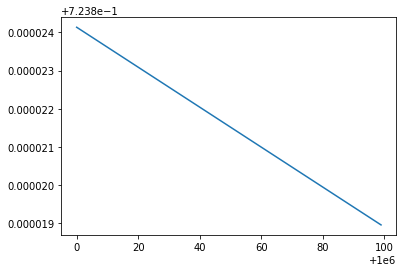

In [62]:
plt.plot(time, epsilon)
plt.show()

In [63]:
np.random.random()
#this has range (0,1)

0.605014259174585

In [64]:
epsilon[0]

0.7238241365054144